# Description

ML model will be predicting the probability of default. 

Due to the specific of available data I'm treating the last availibe clients transactions, as my credit application.   
Default on this transaction is the events that I try to predict.   

I'm not going to focus on model performance, rather this I focus on the process of building models.   

To simplify the task I focuse only on EXISTING CUSTOMER segment and DEFAULT prediction.      
Fof NEW CUSTOMER SEGMENT the fallowing steps should be repeated.   

# Prepare data 


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import viabill
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from category_encoders import WOEEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import lightgbm as lgb

from viabill.pipelines.model import DecisionTreeDiscretizer_DF as DecisionTreeDiscretizer_DF

In [2]:
catalog.list()

df_train = catalog.load('df_train')
df_test = catalog.load('df_test')
df_valid = catalog.load('df_valid')

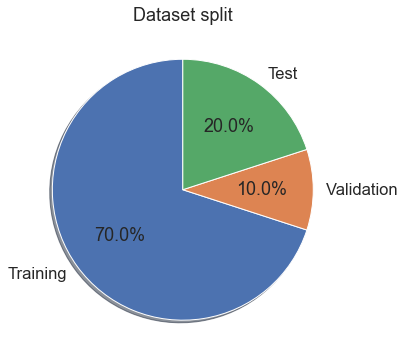

In [3]:

sns.set(font_scale=1.5)

# Pie chart
labels = ['Training', 'Validation ', 'Test']
sizes = [df_train.shape[0], df_valid.shape[0], df_test.shape[0]]
# only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Dataset split')

plt.show()

There are around 450K of observation in the segment of Existing Customer. 

* **df_train** - dataset for model training (EXISTING CUSTOMER),
* **df_test**  - dataset for model performance assessing (out of sample) (EXISTING CUSTOMER),
* **df_valid** - dataset for hp tuning (out of sample) (EXISTING CUSTOMER),


When there isn't so plenty of data, df_valid could be excluded from training data set at the stage of hyperparameter tuning, and put back before final training.

There could be at least one another dataset, but I don't use is because of nature of the data and the fact I don't have transaction date.

* **df_oot** - data set that will allow to check model performance on the latest available data (out of time) (EXISTING CUSTOMER),

Missing values:

In [4]:
print("Nulls percentage:")
(df_train.replace('',np.nan).isna().sum()/ df_train.shape[0]).map(lambda x:'{:.2f}%'.format(x*100)).sort_values(ascending=False).head(10)


Nulls percentage:


postalAddress                    2.01%
postalAddress_clean              2.01%
income                           1.99%
customerID                       0.00%
money_lost_lst_06_sum            0.00%
late_payment_first_lst_06_avg    0.00%
price_lst_06_avg                 0.00%
late_lst_06_avg                  0.00%
money_lost_lst_06_avg            0.00%
defualted_payment_lst_06_avg     0.00%
dtype: object

Missing values in `postalAddress` is not a problem.   
It will be treating as categorical feature so MISSING will be just another feature.    

On the other hand `income` is categorial feature and will be used in Logistic regression.    
I will replace MISSING with a value `-999` that will be an indicator of the missing values and could be used in training.

In [5]:
df_train.fillna({'income':-999}, inplace=True)
df_test.fillna({'income':-999}, inplace=True)
df_valid.fillna({'income':-999}, inplace=True)


# Logistic regression

First I divide features in categories based on their type.   

I remove features `residential Address_clean`, `residential Address` and `shopID` since they are multiple category features, and dimensionality reduction didn't give any value.    
I know from experiments that when transformed using Target encoder method, they tend to overfit the LR model.

I've decided not to spend time fo further improvements in this area, and jus ommite them.   


In [6]:
categorical_cols = ['sex', 
                    'geo_risk_rank', 
                    'same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df_train.filter(regex='(^hist_)|(_lst_)').columns.to_list()

target_def = 'default'
target_late = 'late'

Logistic regression works fine on continuous data but it's much safer to discretize values before training.   
Since sklearn provide only basic discretization method, I use a custom function that I've implemented `DecisionTreeDiscretizer`.    
It builds a Decision Tree clasifier on each single feature and take out `bins` that were created by the Tree.   

After discretization, bins are transformed using `WOEEncoder`.


In [7]:
pipe = make_pipeline(
    ColumnTransformer([
        ('num', DecisionTreeDiscretizer_DF(max_depth = 3, min_samples_prc_leaf=0.05), numerical_cols),
        ('cat', 'passthrough', categorical_cols),
    ]),
    WOEEncoder(random_state=1),
    )

For features selection I use "sequential feature algorithms" from `mlxtend` which ist described in detais [here](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).      

Since it rather computionaly expnsive I use it on data sample rather then on whole train dataset. 

In [8]:
sample = df_train.sample(10000, random_state=1).reset_index(drop=True)

In [9]:
df_train_transfored = pipe.fit_transform(df_train, df_train[target_def])
df_test_transfored = pipe.transform(df_test)
sample_transformed = pipe.transform(sample)

In [10]:
def calculate_IV(column, default_column = 'default', default_val=1, nondefault_val=0, df=df_train, ifprt = False):
    """
    calculate IV - temporary implementation
    """
    total = df.shape[0]
    total_event = np.sum(df[default_column]==default_val)
    total_nonevent= np.sum(df[default_column]==nondefault_val)

    def total_prc(x): return np.round(len(x)/total,4)
    def event_prc(x): return  np.round(len([i for i in list(x) if i==default_val])/total_event,4)
    def nonevent_prc(x): return  np.round(len([i for i in list(x) if i==nondefault_val])/total_nonevent,4)
    def woe(x): return np.log(nonevent_prc(x)/(event_prc(x)+np.finfo(float).eps))
    def iv(x): return (nonevent_prc(x)-event_prc(x))*woe(x)

    wyn = df[[column,default_column]].groupby(column).agg(
        ['count',total_prc,event_prc, nonevent_prc, woe,iv
        ])

    if ifprt:
        print(wyn)
    IV = np.sum(wyn.iloc[:,-1])
    if ifprt:
        print("\n IV value of variable '{}' is {}".format(column,np.round(IV,4)))
    return IV, wyn

In [11]:
# no regularization
model_LR_sfs = LogisticRegression(random_state=1, C=10e6, penalty='l2', max_iter=1000)


In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(model_LR_sfs, 
           k_features=15, 
           forward=True, 
           floating=False, 
           verbose=False,
           scoring='roc_auc',
           cv=3)

sfs1 = sfs1.fit(sample_transformed, sample[target_def])


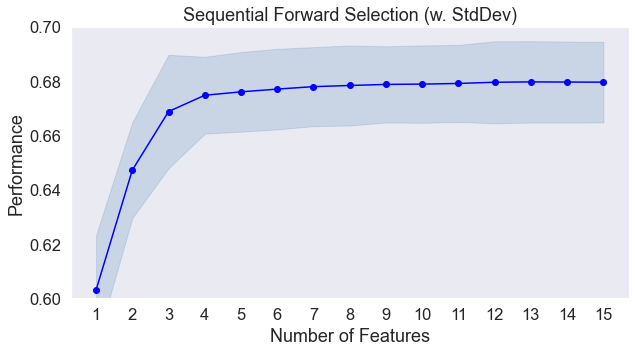

In [13]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev', figsize=(10,5))

plt.ylim([0.6, 0.7])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [14]:
nbr=6
sfs1.get_metric_dict()[nbr]

{'feature_idx': (6, 38, 40, 48, 70, 72),
 'cv_scores': array([0.67747314, 0.69486242, 0.65856531]),
 'avg_score': 0.6769669554500938,
 'feature_names': (6, 38, 40, 48, 70, 72),
 'ci_bound': 0.03335563091758631,
 'std_dev': 0.014822555072440844,
 'std_err': 0.01048112920623398}

In [15]:
columns_transformed = pipe.named_steps['columntransformer'].get_feature_names()
feature_idx = list(sfs1.get_metric_dict()[nbr]['feature_idx'])
best_features_default = list(np.array(columns_transformed)[feature_idx])
best_features_default = [i.replace('num__','').replace('cat__','') for i in best_features_default]

In [16]:
best_features_default

['hist_late_sum',
 'price_lst_06_sum',
 'default_lst_06_avg',
 'money_lost_lst_09_sum',
 'sex',
 'same_address']

<AxesSubplot:>

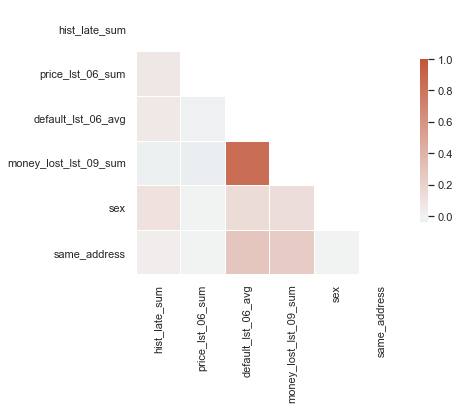

In [17]:
import seaborn as sns
sns.set_theme(style="white")

_tmp = df_train_transfored.iloc[:,feature_idx]
_tmp.columns=best_features_default

corr=_tmp.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Drop `money_lost_lst_09_sum` becouse of too high correlation with `default_lst_06_avg`

In [18]:
features = [i for i in zip(feature_idx,best_features_default) if i[0] != 48 ]

In [19]:
feature_idx = [i[0] for i in features]
best_features_default = [i[1] for i in features]


<AxesSubplot:>

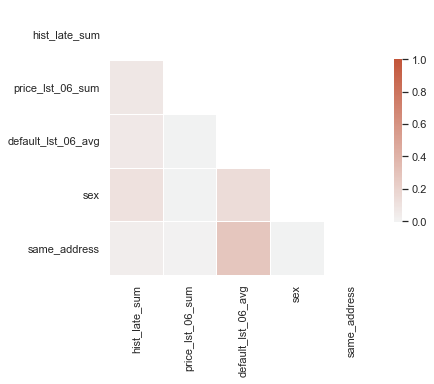

In [20]:
import seaborn as sns
sns.set_theme(style="white")

_tmp = df_train_transfored.iloc[:,feature_idx]
_tmp.columns=best_features_default

corr=_tmp.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
model_LR = LogisticRegression(random_state=1, C=10e6, penalty='l2', max_iter=300)
model_LR.fit(df_train_transfored.iloc[:,feature_idx], df_train[target_def])

LogisticRegression(C=10000000.0, max_iter=300, random_state=1)

Train AUC= 0.665
Test AUC= 0.662


<function matplotlib.pyplot.show(close=None, block=None)>

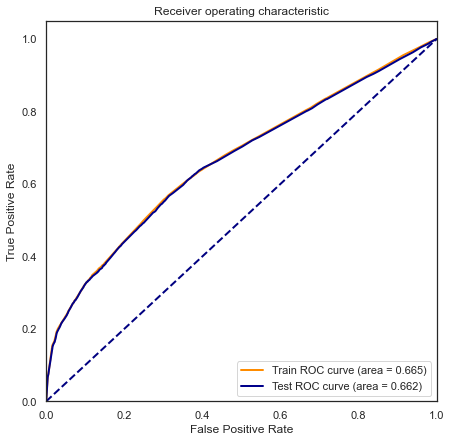

In [22]:
%matplotlib inline

y_pred_train = model_LR.predict_proba(df_train_transfored.iloc[:,feature_idx])[:,1]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(df_train[target_def], y_pred_train, pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
print("Train AUC= %.3f"% roc_auc_train)

y_pred_test = model_LR.predict_proba(df_test_transfored.iloc[:,feature_idx])[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(df_test[target_def], y_pred_test, pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Test AUC= %.3f"% roc_auc_test)  

fig, ax = plt.subplots(figsize=(7,7))
lw = 2
ax.plot(fpr_train, tpr_train,  color='darkorange',
         lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
ax.plot(fpr_test, tpr_test,  color='darkblue',
         lw=lw, label='Test ROC curve (area = %0.3f)' % roc_auc_test)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show

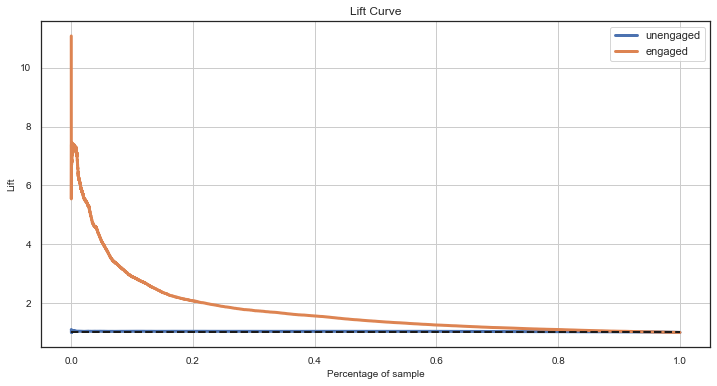

In [23]:
import scikitplot as skplt

fig, ax1 = plt.subplots(figsize=(12,6))



skplt.metrics.plot_lift_curve(
    df_test[target_def].to_list(), 
    model_LR.predict_proba(df_test_transfored.iloc[:,feature_idx]), ax=ax1)
plt.legend(['unengaged','engaged'])
plt.show()

In [24]:
import pandas as pd 
  
# building the model and fitting the data
X = df_train_transfored.iloc[:,feature_idx]
X = sm.add_constant(X)
y = df_train[target_def]

log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.281626
         Iterations 7


In [25]:
print(log_reg.summary(xname=['const']+best_features_default))

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               316942
Model:                          Logit   Df Residuals:                   316936
Method:                           MLE   Df Model:                            5
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:                 0.07560
Time:                        08:48:53   Log-Likelihood:                -89259.
converged:                       True   LL-Null:                       -96559.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2984      0.007   -352.184      0.000      -2.311      -2.286
hist_late_sum          0.2152      0.069      3.103      0.002       0.079       0.351
price_lst_06_sum    

In [26]:
y_pred_train_lr = model_LR.predict_proba(df_train_transfored.iloc[:,feature_idx])[:,1]
y_pred_test_lr = model_LR.predict_proba(df_test_transfored.iloc[:,feature_idx])[:,1]


# LightGBM + HyperOpt

In [27]:
import category_encoders as ce
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


In [28]:
params = catalog.load('model_lgb_params')
parameters = catalog.load('params:hp_params')


In [29]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'postalAddress_clean', 'geo_risk_rank', 'shopID',
                    'same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df_train.filter(regex='(^hist_)|(_lst_)').columns.to_list()
target_column = ['default']

transformer = make_pipeline(
    ColumnTransformer([
        ('num', 'passthrough', numerical_cols),
        ('cat', ce.OrdinalEncoder(), categorical_cols),
    ]),
)

transformer.fit(df_train, df_train[parameters["target"]])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'income', 'price',
                                                   'hist_trans_count',
                                                   'hist_default_sum',
                                                   'hist_default_avg',
                                                   'hist_late_sum',
                                                   'hist_late_avg',
                                                   'hist_price_sum',
                                                   'hist_price_avg',
                                                   'default_lst_01_sum',
                                                   'defualted_payment_lst_01_sum',
                                                   'money_lost_lst_01_sum',
                                                   'late_lst_01_sum',
                        

In [30]:
d_train = lgb.Dataset(
    transformer.transform(df_train),
    label=df_train['default'],
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_valid = lgb.Dataset(
    transformer.transform(df_valid),
    label=df_valid[parameters["target"]],
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

In [31]:

params['deterministic'] = True
params['objective'] = "binary"
params['boosting'] = "gbdt"
params['metric'] = ['auc', 'average_precision', 'binary_logloss']
params['seed'] = '666'
params['feature_pre_filter'] = False

train_params = {
    'num_boost_round': parameters['num_boost_round'],
    'verbose_eval': parameters['verbose_eval'],
    'early_stopping_rounds': parameters['early_stopping_rounds'],
}

model = lgb.train(
    params,
    d_train,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
    **train_params,
)



[LightGBM] [Info] Number of positive: 28816, number of negative: 288126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7891
[LightGBM] [Info] Number of data points in the train set: 316942, number of used features: 76


In [32]:
y_predict_test = model.predict(transformer.transform(df_test))

roc_auc_score(df_test['default'], y_predict_test)


0.6686796291763554

Train AUC= 0.670
Test AUC= 0.669


<function matplotlib.pyplot.show(close=None, block=None)>

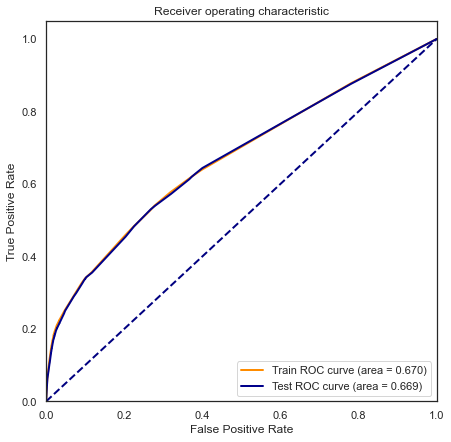

In [33]:
%matplotlib inline

y_pred_train = model.predict(transformer.transform(df_train))
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(df_train[target_def], y_pred_train, pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
print("Train AUC= %.3f"% roc_auc_train)

y_pred_test = model.predict(transformer.transform(df_test))
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(df_test[target_def], y_pred_test, pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Test AUC= %.3f"% roc_auc_test)  

fig, ax = plt.subplots(figsize=(7,7))
lw = 2
ax.plot(fpr_train, tpr_train,  color='darkorange',
         lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
ax.plot(fpr_test, tpr_test,  color='darkblue',
         lw=lw, label='Test ROC curve (area = %0.3f)' % roc_auc_test)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show

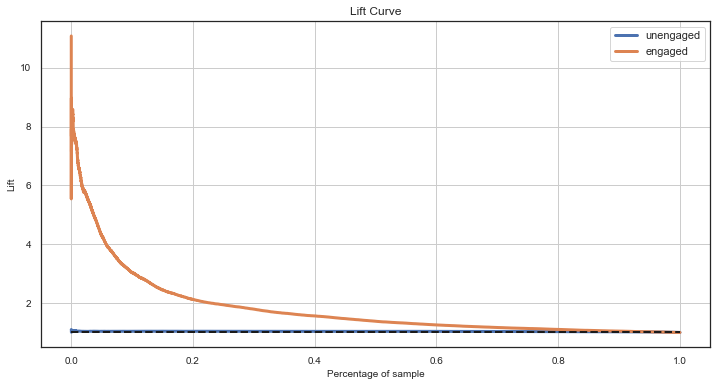

In [34]:
import scikitplot as skplt

fig, ax1 = plt.subplots(figsize=(12,6))



skplt.metrics.plot_lift_curve(
    df_test[target_def].to_list(), 
    np.array([[1-i,i] for i in y_pred_test]), ax=ax1)
plt.legend(['unengaged','engaged'])
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

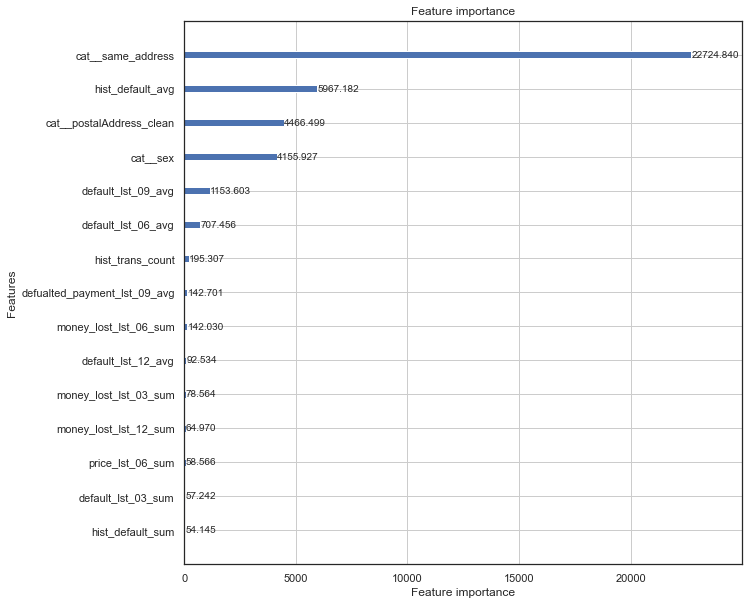

In [35]:
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=15, ax=ax2, importance_type = 'gain')